## Explanatory Notebook


*Notebook for **Risk-Aware Reinforcement Learning for Goal-Based Portfolio Optimisation**, by Mathew Cater Benavides and Sebastian Jaimungal*,

This Jupyter notebook showcases how to use the Python files for using our proposed deep policy gradient algorithm and reproducing some of the main figures in the experiments section. All the Python code and modules are publicly available in the Github repository.

### 1. Importation of Python Libraries

We load some basic Python libraries, such as NumPy, PyTorch, SciPy and Matplotlib.

In [33]:
# numpy
import numpy as np

# plotting
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# pytorch
import torch as T

# misc
from time import time
from tqdm import tqdm
from torch.nn import ReLU
np.seterr(divide='ignore', invalid='ignore')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Palatino"
})

We as well load the relevant classes and functions in our Python modules and refer the user to the Python files for a description of all functions in the modules. Furthermore, the user can modify these files to consider non-investigated market models or risk measures.

In [2]:
from utils import cmap, colors # colors
from hyperparams import init_params, print_params # hyperparameters
from models import PolicyANN # ANN structures
from envs import BS_Environment # environment
from agents import Agent # Deep Policy Gradient algorithm

### 2. Initialisation of Training Hyperparameters

In [3]:
market_model = "Black_Scholes" # specify the market model
env_params, algo_params = init_params(market_model) # all hyperparameters
print_params(env_params, algo_params)



*  Drifts:  tensor([0.0800, 0.0500]) 
   Volatilites:  tensor([0.0200, 0.0300]) 
   Initial Prices:  tensor([1., 1., 1.])  Initial Interest rate:  0.025  Initial Wealth:  100.0  T:  1  Number of periods:  10
*  Batch size:  250  Number of epochs:  100
*  Learning Rate:  0.1  Width of Hidden Layers:  16  Number of Hidden Layers:  10


We instantiate the environment from the envs.py file to get functions to interact with the data-generating processes.

In [4]:
env = BS_Environment(env_params)

### 3. Training of Risk-Aware Agents & Initialisation of Testing Parameters

We initialise the neural network structure for our algorithm from the **models.py** file, we as well instantiate our risk-aware agent from the *agents.py* file with the aforementioned policy, environment and algorithm specifications. The $\texttt{Agent()}$ class regroups the different routines to solve our optimisation problem. We have respectively:

- an ANN representing the policy $\pi^{\theta}$;
- an $\texttt{Agent()}$ object representing the risk-aware agent with the aforementioned specifications.

In [5]:
policy = PolicyANN(env, algo_params)
agent = Agent(env=env, # environment
              algo_params=algo_params, # algorithm specifications 
              policy=policy) # policy

We next start the training phase of our deep policy gradient algorithm -- this corresponds to the Algorithm 5.1 presented in our paper. We as well set up hyperparameters for the testing phase, in particular, the number of episodes and the seed for the random number generator. 

In [6]:
seed = 4321 # set seed for replication purposes
Nsimulations = 30_000 # number of simulations following the optimal strategy

In [7]:
# time the algorithm
start_time = time()

for epoch in tqdm(range(agent.algo_params["num_epochs"])):
            
    # at final epoch of training, store probability of meeting goal, distribution of term. wealth and 
    # position history over final mini-batch
    if epoch == agent.algo_params["num_epochs"] - 1:
        agent.algo_params["batch_size"] = 10_000
        
        # update policy     
        _, RDEU, return_prob, term_wealth_samps, pi = agent.update_policy() 
        
        # store RDEU to track training
        agent.update_history(RDEU, return_prob) 
        
        # store store prob. of meeting goal, dist. of term. wealth and action hist.
        agent.term_wealth_dist = term_wealth_samps 
        agent.return_prob = return_prob
        agent.pi = pi
    
    else:
        # update policy     
        _, _, return_prob, term_wealth_samps, pi = agent.update_policy() 
        
        # update Lagrange multipliers
        if epoch % agent.algo_params["pen_update_freq"] == 0:
            agent.update_multipliers(constr_err=ReLU()(agent.env.params["goal_prob"] 
                                                        - return_prob))    
    start_time = time()

  0%|          | 0/100 [00:00<?, ?it/s]/Users/mathewcaterbenavides/Desktop/Risk-Aware-Goal-Based-Investing/models.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y[...,1:(1+len(self.env.params['S0']))] = (y[...,1:(1+len(self.env.params['S0']))] / T.tensor(self.env.params['S0'])) - 1.0
  2%|▏         | 2/100 [00:00<00:13,  7.27it/s]

100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


### 4. Testing of Risk-Aware Agents


##### 4.1 Distribution of Terminal Wealth

We investigate the terminal wealth distribution when the agent adheres to the learned optimal policy. To accomplish this, we execute a large batch of complete episodes in accordance with the learned policy. We as well report the probability that the agent achieves their desired realised gain.

Probability of return exceeding 5.0%: 93.134%


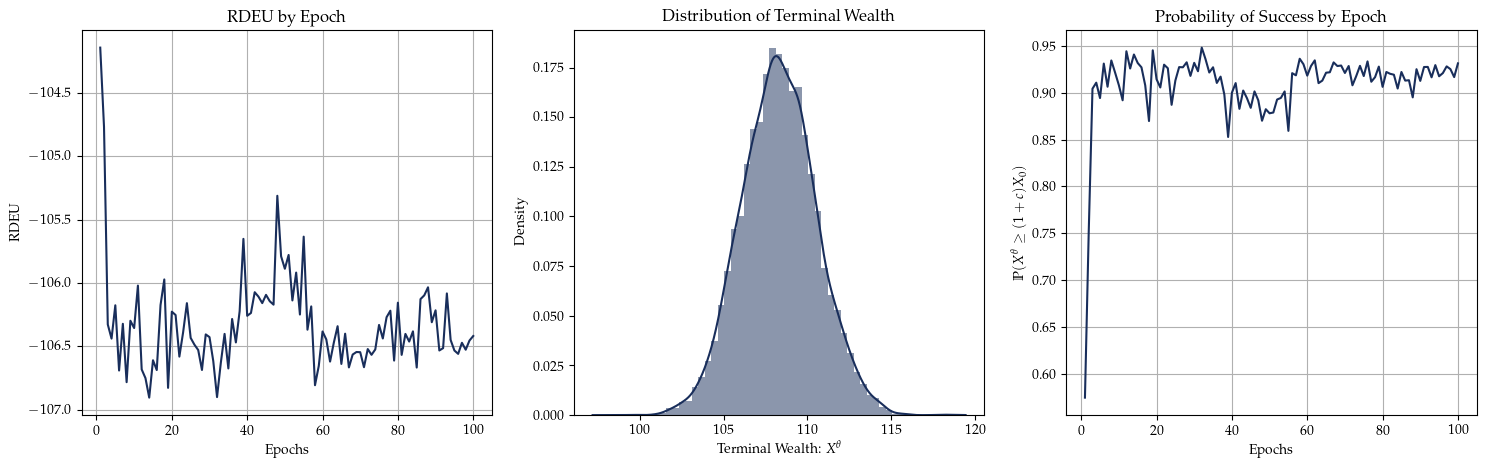

In [43]:
(fig, ax) = plt.subplots(1, 3, figsize=(18,5))  \
                            
# plot RDEU through training
ax[0].plot(np.arange(algo_params["num_epochs"]) + 1, 
                     T.stack(agent.RDEU_history)[:-1], 
                     color=colors[0])
ax[0].set(xlabel='Epochs', ylabel='RDEU', title='RDEU by Epoch')    
ax[0].grid()

# plot terminal wealth distribution of learned strategy using 30,000 full episodes
term_wealth = agent.term_wealth_dist.detach().squeeze()
mean_term_wealth, std_term_wealth = T.mean(term_wealth), T.std(term_wealth)
num_bins = 50
domain = np.linspace(mean_term_wealth - 5*std_term_wealth, mean_term_wealth + 5*std_term_wealth, 1500)
term_wealth_kde = gaussian_kde(term_wealth)
ax[1].hist(term_wealth, density=True, bins=num_bins, color=colors[0], alpha=0.5)
ax[1].set(title=r'Distribution of Terminal Wealth', xlabel=r'Terminal Wealth: $X^{\theta}$', ylabel='Density')
ax[1].plot(domain, term_wealth_kde(domain), color=colors[0])

# plot probability of posting desired return through training
ax[2].plot(np.arange(algo_params["num_epochs"]) + 1,
                     T.stack(agent.constraint_prob_history)[:-1],
                     color=colors[0])
ax[2].set(xlabel='Epochs', ylabel=r'$\mathbb{P}(X^\theta \geq (1+c)X_0)$', title='Probability of Success by Epoch')    
ax[2].grid()

# check if constraint satisfied
c = env_params["returns_req"]
print(f'Probability of return exceeding {100*c}%: {str(round(float(100*agent.return_prob), 3))}%')
plt.show() 